#  CIFAR 10 이미지 분류하기

- 이미지 데이터를 읽고, 라벨을 직접 만들어서 딥러닝 CNN 모델로 인식하기

- https://pjreddie.com/projects/cifar-10-dataset-mirror/

작업 순서
1. 데이터셋 획득 Download/ 압축 해제
2. (X)이미지 > 수치 배열로 변환 , (Y)이미지의 클래스-라벨
3. 정규화(0~1) Normalization - 모델안에서 구현
4. CNN 모델을 구현
5. trainset 으로 학습
6. testset 성능을 평가(accuracy 정확도), confusion matrix

# 이미지 1장 읽기

In [21]:
FOLDER_ROOT = './cifar/'
sample = FOLDER_ROOT + 'train/0_frog.png'
FOLDER_TRAIN  = FOLDER_ROOT + 'train/*.png'
FOLDER_TEST   = FOLDER_ROOT + 'test/*.png'

In [2]:
from PIL import Image
import numpy as np

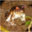

In [3]:
image = Image.open(sample)
image

In [4]:
arr = np.array(image)
arr.shape

(32, 32, 3)

In [6]:
sample

'./cifar/train/0_frog.png'

In [9]:
start = sample.index('_')

In [10]:
end = sample.index('.png')

In [14]:
label = sample[start+1:end]
label

'frog'

In [16]:
class_str = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
len(class_str)

10

In [18]:
class_str.index(label)

6

In [19]:
import glob

In [29]:
path_train = glob.glob(FOLDER_TRAIN)
len(path_train), path_train[0:2]

(50000, ['./cifar/train\\0_frog.png', './cifar/train\\10000_automobile.png'])

In [44]:
def parse_folder(folder, m_max):
    path_train = glob.glob(folder)
    m = np.minimum(m_max,len(path_train))
    list_x = []
    list_y = []
    for i in range(m):
        path_img = path_train[i]
        image = Image.open(path_img)
        arr = np.array(image)
        list_x.append(arr)
        
        start = path_img.index('_')
        end = path_img.index('.png')
        label = path_img[start+1:end]
        label_index = class_str.index(label)
        list_y.append(label_index)
    
    return np.array(list_x), np.array(list_y)            

In [70]:
m_max = 1000
train_x, train_y = parse_folder(FOLDER_TRAIN, m_max)
test_x, test_y = parse_folder(FOLDER_TEST, m_max)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1000, 32, 32, 3), (1000,), (1000, 32, 32, 3), (1000,))

In [72]:
train_x.dtype

dtype('uint8')

### CNN 모델 구현 : 네트워크를 어떻게 구성할것인가
- 입력데이터 : (32, 32, 3) (높이, 너비, 채널) 개구리
- 중간을 conv, pooling 으로 구성을 한다.
- conv : kernel (3x3), output : 16, stride 1, paddig='SAME' > (32, 32, 16) 
- max pool : kernel (2x2), stride 2 > (16, 16, 16)
- conv : kernel (3x3), output : 32, stride 1 > (16, 16, 32)
- max pool : kernel (4x4), stride 4 > (4, 4, 16)
- conv : kernel (4x4), output : 10, stride 1, padding='VALID' > (1, 1, 10)
- (1,1,10) > [0,0] > (10), flatten(펼치다)
- 출력 : (10) : 10개의 클래스 중 무엇이냐 score 
         'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'
         (   5점,        3점,      7점,   8점...      9점,   30점,   12점,  3점,   4점   )
          


In [51]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [59]:
def feed(X):
    #X : (m:1000, 32, 32, 3) X 값 [0~255] uint8
    x_norm = tf.cast(X, tf.float32) / 255.0 # [0.0 ~ 1.0]  실수
    net = slim.conv2d(x_norm, 16, (3,3))
    print('net', net)
    net = slim.max_pool2d(net, (2,2), 2)
    print('net', net)
    net = slim.conv2d(net, 32, (3,3))
    print('net', net)
    net = slim.max_pool2d(net, (4,4), 4)
    print('net', net)
    net = slim.conv2d(net, 10, (4,4), 4, padding='VALID')
    print('net', net)# (m, 1, 1, 10)
    score = net[:,0,0] # (m:1000, 10)
    score = slim.flatten(net)
    print('score', score)
    return score 

In [63]:
m, h, w, c = tain_x.shape
PX = tf.placeholder(tf.uint8, [None, h, w, c])
PY = tf.placeholder(tf.int64, [None])
score = feed(PX)

net Tensor("Conv_12/Relu:0", shape=(?, 32, 32, 16), dtype=float32)
net Tensor("MaxPool2D_8/MaxPool:0", shape=(?, 16, 16, 16), dtype=float32)
net Tensor("Conv_13/Relu:0", shape=(?, 16, 16, 32), dtype=float32)
net Tensor("MaxPool2D_9/MaxPool:0", shape=(?, 4, 4, 32), dtype=float32)
net Tensor("Conv_14/Relu:0", shape=(?, 1, 1, 10), dtype=float32)
score Tensor("Flatten_1/flatten/Reshape:0", shape=(?, 10), dtype=float32)


In [65]:
predict = tf.argmax(score, axis=1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predict, PY),tf.float32)) # True > 1.0, False > 0.0
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=PY, logits=score))
opt = tf.train.GradientDescentOptimizer(0.01)
train_op = opt.minimize(cost)

In [66]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [67]:
sess = tf.Session()

In [68]:
sess.run(tf.global_variables_initializer())

In [84]:
EPOCH = 5000
for iter in range(EPOCH):
    _, cost_train, acc_train = sess.run([train_op, cost, accuracy], feed_dict={PX:tain_x, PY:train_y})
    if iter%100==0:
        acc_test = sess.run(accuracy, feed_dict={PX:test_x, PY:test_y})
        print("%d, cost:%.5f, acc:(%.2f, %.2f)" %(iter, cost_train, acc_train, acc_test))

0, cost:0.87770, acc:(0.68, 0.35)
100, cost:0.79964, acc:(0.68, 0.35)
200, cost:0.79580, acc:(0.68, 0.35)
300, cost:0.79781, acc:(0.68, 0.35)
400, cost:0.79593, acc:(0.68, 0.35)
500, cost:0.79264, acc:(0.68, 0.36)
600, cost:0.79015, acc:(0.68, 0.35)
700, cost:0.78965, acc:(0.68, 0.35)
800, cost:0.78694, acc:(0.68, 0.35)
900, cost:0.78583, acc:(0.68, 0.35)
1000, cost:0.78463, acc:(0.68, 0.35)
1100, cost:0.78643, acc:(0.68, 0.36)
1200, cost:0.78286, acc:(0.68, 0.35)
1300, cost:0.78995, acc:(0.68, 0.36)
1400, cost:0.78787, acc:(0.68, 0.36)
1500, cost:0.78060, acc:(0.68, 0.36)
1600, cost:0.77932, acc:(0.68, 0.35)
1700, cost:0.77875, acc:(0.68, 0.35)
1800, cost:0.77708, acc:(0.68, 0.35)
1900, cost:0.77646, acc:(0.68, 0.35)
2000, cost:0.77604, acc:(0.68, 0.35)
2100, cost:0.77403, acc:(0.68, 0.35)
2200, cost:0.77348, acc:(0.68, 0.35)
2300, cost:0.77309, acc:(0.68, 0.35)
2400, cost:0.77188, acc:(0.68, 0.36)
2500, cost:0.77215, acc:(0.68, 0.36)
2600, cost:0.77083, acc:(0.68, 0.36)
2700, cost:0.

In [79]:
from sklearn.metrics import confusion_matrix

In [83]:
class_str

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [94]:
pred_y = sess.run(predict, feed_dict={PX:tain_x})
confusion_matrix(train_y, pred_y)

array([[ 99,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  4,  96,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 52,   2,  15,   0,   8,   0,   2,   1,   0,   0],
       [ 15,   0,   0,  82,   0,   0,   0,   0,   1,   0],
       [ 16,   1,   0,   0,  88,   0,   0,   0,   0,   0],
       [ 89,   1,   0,   0,   2,   0,   1,   1,   0,   0],
       [  8,   1,   0,   0,   0,   0,  93,   0,   0,   0],
       [  7,   1,   0,   0,   0,   0,   0, 109,   0,   0],
       [  9,   1,   0,   0,   1,   0,   0,   0, 100,   0],
       [ 76,  16,   0,   0,   0,   0,   0,   0,   2,   0]], dtype=int64)

In [93]:
pred_y = sess.run(predict, feed_dict={PX:test_x})
confusion_matrix(test_y, pred_y)

array([[58, 10,  1,  3,  5,  0,  2,  1, 14,  0],
       [18, 60,  2,  5,  1,  0,  5,  4, 12,  0],
       [34,  4,  4, 15, 21,  0,  8,  9,  2,  0],
       [17,  9,  4, 31,  8,  0, 14,  9,  3,  0],
       [12,  6,  0, 14, 46,  0, 12, 13,  2,  0],
       [26,  4,  7, 21, 11,  0, 11, 17,  3,  0],
       [ 8,  6,  1, 13, 13,  0, 51,  9,  0,  0],
       [20,  4,  2, 10, 10,  0,  1, 42,  1,  0],
       [29, 15,  1,  0,  3,  0,  2,  2, 63,  0],
       [31, 26,  0,  6,  4,  0,  8,  9, 12,  0]], dtype=int64)